In [6]:
import pandas as pd
from plotnine import ggplot,geom_point,aes,theme_bw
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/BDC/Projects/Viral Shah/GMI and A1c/'

# Data Cleaning
- HbA1c and mean glucose data were pulled from Kaan's data, CGMND, FLAIR, MOBILE, CITY, DCLP3, WISDM, and data from Peter including participants from DIAMOND, REPLACE, and HypoDE.

In [14]:
# Import Kaan's data (use clean_cgms.py to generate mean glucose file)
# Had to manually edit some names in glucose file to match demographics
kaan = pd.read_csv(wd + 'Data_Clean/kaan_mean_glucose.csv',usecols=['ID','HbA1c','14 Overall Mean'])
kaan.columns = ['ID','HbA1c','Mean Glucose']
# CGMND
cgmnd_a1c = pd.read_csv(wd+'Data_Raw/CGMND-af920dee-2d6e-4436-bc89-7a7b51239837/NonDiabSampleResults.csv')
cgmnd_a1c = cgmnd_a1c[cgmnd_a1c['Analyte'] == "HBA1C"]
cgmnd_a1c = cgmnd_a1c[['PtID','Value']]
cgmnd_a1c.columns = ['ID','HbA1c']
# Calculate mean glucose for each person in CGMND
cgmnd_cgm = pd.read_csv(wd+'Data_Raw/CGMND-af920dee-2d6e-4436-bc89-7a7b51239837/NonDiabDeviceCGM.csv')
ids = cgmnd_cgm['PtID'].unique()
msgs = {'ID':[],'Mean Glucose':[]}
for i in ids:
    d = cgmnd_cgm[(cgmnd_cgm['PtID'] == i) & (cgmnd_cgm['RecordType'] == "CGM")]
    msgs['ID'].append(i)
    msgs['Mean Glucose'].append(d['Value'].mean())
cgmnd_cgm = pd.DataFrame(msgs)
# Merge
cgmnd = pd.merge(cgmnd_a1c,cgmnd_cgm,on='ID')
# FLAIR
flair = pd.read_csv(wd+'Data_Raw/gmiDataFlair 042222 .csv',usecols=['DeidentID','a1cLab','gluMean'])
flair.columns = ['ID','HbA1c','Mean Glucose']
# MOBILE
mobile = pd.read_csv(wd+'Data_Raw/gmiDataMobile 031722 .csv',usecols=['DeidentID','a1cLab','gluMean'])
mobile.columns = ['ID','HbA1c','Mean Glucose']
# DIAMOND, etc
diamond = pd.read_csv(wd+'Data_Raw/gmiData 020222 .csv',usecols=['DeidentID','a1cLab','gluMean'])
diamond.columns = ['ID','HbA1c','Mean Glucose']
# CITY
city = pd.read_csv(wd+'Data_Raw/CITYPublicDataset-344bea7d-8085-4deb-8038-6cb747a744e3/Data Tables/gluIndices Ext.txt',sep='|')
city = city[city['time'] == '1) Overall']
city['Visit'] = [v.lower() for v in city['Visit']]
city_a1c = pd.read_csv(wd+'Data_Raw/CITYPublicDataset-344bea7d-8085-4deb-8038-6cb747a744e3/Data Tables/vwCITY_STASampleResults.txt',sep='|',encoding='utf-16')
city_a1c = city_a1c[city_a1c['ResultName'] == 'GLYHB']
city_a1c['Visit'] = [v.lower() for v in city_a1c['Visit']]
city = pd.merge(city_a1c,city,on=['PtID','Visit'])
city = city[['PtID','Value','gluMean']]
city.columns = ['ID','HbA1c','Mean Glucose']
# DCLP3

# WISDM
wisdm = pd.read_csv(wd+'/Data_Raw/WISDMPublicDataset-18f24ae5-b4fb-4e93-bec6-7021086419fa/Data Tables/gluIndices Ext.txt',sep='|')
wisdm = wisdm[wisdm['time'] == '1) Overall']
wisdm_a1c = pd.read_csv(wd+'Data_Raw/WISDMPublicDataset-18f24ae5-b4fb-4e93-bec6-7021086419fa/Data Tables/STASampleResults.txt',sep='|',encoding='utf-16')
wisdm_a1c = wisdm_a1c[wisdm_a1c['ResultName'] == 'GLYHB']
wisdm = pd.merge(wisdm_a1c,wisdm,left_on=['PtID','Visit'],right_on=['PtID','visit'])
wisdm = wisdm[['PtID','Value','gluMean']]
wisdm.columns = ['ID','HbA1c','Mean Glucose']
# Combine everything
gmi_data = pd.concat([kaan,cgmnd,flair,mobile,diamond,city,wisdm])
# As numeric
gmi_data['HbA1c'] = [float(n) for n in gmi_data['HbA1c']]
gmi_data['Mean Glucose'] = [float(n) for n in gmi_data['Mean Glucose']]
# Calculate GMI
gmi_data['GMI'] = [(3.31 + (0.02392*n)) for n in gmi_data['Mean Glucose']]

In [3]:
# dclp3 = pd.read_csv(wd+'Data_Raw/DCLP3 Public Dataset - Release 2 - 2022-01-18-9fc308ee-5d12-4651-8aec-262576777a31/Data Files/gluIndices.txt',sep='|')
# dclp3 = dclp3[dclp3['analysis'] == "1. 24hr"]
# dclp3_a1c = pd.read_csv(wd+'Data_Raw/DCLP3 Public Dataset - Release 2 - 2022-01-18-9fc308ee-5d12-4651-8aec-262576777a31/Data Files/SampleResults_a.txt',sep='|')
# dclp3_a1c = dclp3_a1c[dclp3_a1c['ResultName'] == 'GLYHB']

# Plot

/opt/homebrew/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 15 rows containing missing values.


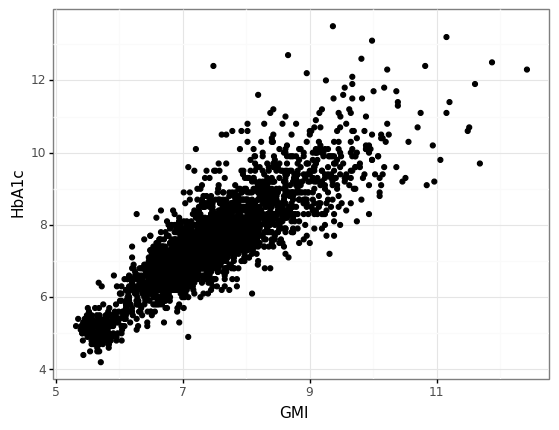

<ggplot: (379074606)>

In [15]:
(ggplot(gmi_data,aes(x = 'GMI',y = 'HbA1c')) + geom_point() + theme_bw())

# GAM

In [ ]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.tests.test_penalized import df_autos

# Questions for Peter
- Is "vwCITY_STASampleResults.txt" the correct file for CITY HbA1c results?
    - Currently matching these A1cs to the mean glucoses in "gluIndices Ext.txt" (overall mean only, ignoring day and night)
- DCLP3 "SampleResults_a.txt" has randomization, 13 week, and 26 week values, but "gluIndices.txt" has baseline and post-randomization values. How to match them up?
- For people with multiple measures, do we use them all and treat them independently? Would we assume higher correlation between GMI and HbA1c within a person? 